# CSCA 5642 Final Project

## Problem Statement
The goal of this project is to use deep learning to create a model that can predict missing words in a sentance. This will be a fill in the blank Natural Language Processing task. As the nature of this problem is sequence based and context dependent, reccurent neural networks will be explored for this task.


### Data Description

According to the Kaggle page this was sourced, this dataset includes approximately 40MB JSON files. They are each contain a collection of Wikipedia articles. Each article element in the JSON contains only 3 keys: an ID number, the title of the article, and the text of the article. Each article has been "flattened" to occupy a single plain text string to make it easier for human examination, as opposed to markup. An example entry is of the form:

[
 {
  "id": "17279752",
  "text": "Hawthorne Road was a cricket and football ground in Bootle in England...",
  "title": "Hawthorne Road"
 }
]

There is a significantly large amount of data. For the sake of model training time, I will be using a small subset of the data.

Source: https://www.kaggle.com/datasets/ltcmdrdata/plain-text-wikipedia-202011/data

### Setup

#### Imports

In [1]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import os
import seaborn
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import train_test_split
import sys
import nltk
import json
from nltk.corpus import stopwords
import re
from PIL import Image
import random
from wordcloud import WordCloud
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Bidirectional, LSTM
import glob
from nltk.tokenize import sent_tokenize
import time
from sklearn.metrics import accuracy_score

In [363]:
nltk.download('stopwords')

In [365]:
nltk.download('punkt')

In [367]:
nltk.download('punkt_tab')

### Load Data
There are a very large amount of files available. I will only be taking 1 file for this experiment for the sake of training time for comparing multiple models.

In [370]:
jsons = glob.glob("data/*.json")

In [8]:
with open(jsons[0], 'r') as file:
  data = json.load(file)
print(data[0].keys())
json_data = pd.DataFrame(data)

dict_keys(['id', 'text', 'title'])


In [9]:
print(json_data.columns, '\n------------------------------------------------------------------------------------')
print(json_data.describe(), '\n------------------------------------------------------------------------------------')
print(json_data.info(), '\n------------------------------------------------------------------------------------')
json_data

Index(['id', 'text', 'title'], dtype='object') 
------------------------------------------------------------------------------------
              id   text          title
count      14012  14012          14012
unique     14012  14011          14012
top     53158230         Aulacaganides
freq           1      2              1 
------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      14012 non-null  object
 1   text    14012 non-null  object
 2   title   14012 non-null  object
dtypes: object(3)
memory usage: 328.5+ KB
None 
------------------------------------------------------------------------------------


,id,text,title
0,53158230,Aulacaganides is monospecific genus of a Middl...,Aulacaganides
1,53158236,"Mikko Outinen (born April 7, 1971) is a Finnis...",Mikko Outinen
2,53158237,Edith Beatrice Belcher Thurston (Birthdate Unk...,Edith Thurston
3,53158281,The presidency of Dwight D. Eisenhower began o...,Timeline of the Dwight D. Eisenhower presidency
4,53158311,"is a Japanese actor, voice actor and narrator....",Shinya Owada
...,...,...,...
14007,53351308,"Lubnowy is part of the name of two villages, b...",Lubnowy
14008,53351318,Rhamphomyia albohirta is a species of fly in t...,Rhamphomyia albohirta
14009,53351334,"Jawty () is part of the name of two villages, ...",Jawty
14010,53351338,Spliatsch Castle () is a ruined castle in the ...,Spliatsch Castle


## Exploratory Data Analysis
The text data has already been cleaned of html. The text had also already been flattened to one string, so this step is already accomplished. Some options for further processing include stopword removal, casting the text to lower case, and removing special characters. Since the goal is to create a model that can fill in the blank, stopword removal will not be used. The text will however be cast to lowercase, and removed of special characters and numbers.

Also, the id and title columns are not needed so they will be removed. The method I will approach this NLP deep learning problem is to create a target column containing the word to be predicted (filled in). This word in the original text will be switched with a mask token <MASK>. The input text will also be reformatted so that each row is a single sentance, thus expanding the input count.

Perform the required cleaning operations.

In [12]:
json_data = json_data.drop(['id', 'title'], axis=1)
json_data

,text
0,Aulacaganides is monospecific genus of a Middl...
1,"Mikko Outinen (born April 7, 1971) is a Finnis..."
2,Edith Beatrice Belcher Thurston (Birthdate Unk...
3,The presidency of Dwight D. Eisenhower began o...
4,"is a Japanese actor, voice actor and narrator...."
...,...
14007,"Lubnowy is part of the name of two villages, b..."
14008,Rhamphomyia albohirta is a species of fly in t...
14009,"Jawty () is part of the name of two villages, ..."
14010,Spliatsch Castle () is a ruined castle in the ...


In [13]:
## Some non related article text is contained. A lot have text between double == that needs removal

json_data.iloc[-4].text

'Rhamphomyia albohirta is a species of fly in the family Empididae. It is found in the Palearctic .Fauna EuropaeaBei-Bienko, G.Y. & Steyskal, G.C. (1988) Keys to the Insects of the European Part of the USSR, Volume V: Diptera and Siphonaptera, Parts I, II. Amerind Publishing Co., New Delhi. Collin, J.E. (1961) British Flies. VI. Empididae. Cambridge: Cambridge University Press. ==References== ==External links== *Images representing Rhamphomyia at BOLD *Ecology of Commanster Category:Empididae Category:Insects described in 1926 Category:Asilomorph flies of Europe '

In [14]:
## Remove all text between == == in json_data text column

def remove_text_between_equals(text):
  return re.sub(r'==.*?==', '', text)

json_data['text'] = json_data['text'].apply(remove_text_between_equals)
json_data.iloc[-4].text

'Rhamphomyia albohirta is a species of fly in the family Empididae. It is found in the Palearctic .Fauna EuropaeaBei-Bienko, G.Y. & Steyskal, G.C. (1988) Keys to the Insects of the European Part of the USSR, Volume V: Diptera and Siphonaptera, Parts I, II. Amerind Publishing Co., New Delhi. Collin, J.E. (1961) British Flies. VI. Empididae. Cambridge: Cambridge University Press.   *Images representing Rhamphomyia at BOLD *Ecology of Commanster Category:Empididae Category:Insects described in 1926 Category:Asilomorph flies of Europe '

In [15]:
## Split the text in json_data into sentances, then assign each sentence to it's own row.

json_data_cleaned = json_data.copy()
json_data_cleaned['sentences'] = json_data_cleaned['text'].apply(sent_tokenize)
json_data_cleaned = json_data_cleaned.explode('sentences')
json_data_cleaned = json_data_cleaned.reset_index(drop=True).drop(columns = {'text'}).dropna()
json_data_cleaned

,sentences
0,Aulacaganides is monospecific genus of a Middl...
1,Fossils belonging to this genera were found in...
2,"This genus has small, involute and thickly dis..."
3,Venter is rounded with gently convex lateral s...
4,Growth lines and constrictions are forming a s...
...,...
266077,In 2015 an effort was made to improve the near...
266078,A museum exhibit was created in 2016 for the O...
266079,"The exhibit contains photographs, tools, testi..."
266080,"= George R. Downer (January 1890 – January 1, ..."


In [16]:
## Helper function to clean the text

def remove_special_chars(text):
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non - ASCII characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Remove special characters except spaces
    return text

In [17]:
## Lowercase the sentences text and remove special characters

json_data_cleaned['sentences'] = json_data_cleaned['sentences'].str.lower()
json_data_cleaned['sentences'] = json_data_cleaned['sentences'].apply(remove_special_chars)
json_data_cleaned

,sentences
0,aulacaganides is monospecific genus of a middl...
1,fossils belonging to this genera were found in...
2,this genus has small involute and thickly disc...
3,venter is rounded with gently convex lateral s...
4,growth lines and constrictions are forming a s...
...,...
266077,in 2015 an effort was made to improve the near...
266078,a museum exhibit was created in 2016 for the o...
266079,the exhibit contains photographs tools testimo...
266080,george r downer january 1890 january 1 1915 ...


Setup the new input and target columns using masked sentences and the masked word.

In [19]:
## Randomly mask a word in each row in json_data, then add that word to an associated target column.

def mask_word(text):
    words = text.split()
    if not words:  # Handle empty strings
        return text, ""
    random_index = random.randint(0, len(words) - 1)
    target_word = words[random_index]
    words[random_index] = "<MASK>"
    masked_text = " ".join(words)
    return masked_text, target_word

json_data_cleaned[['masked_sentences', 'target']] = json_data_cleaned['sentences'].apply(lambda x: pd.Series(mask_word(x)))
json_data_cleaned

,sentences,masked_sentences,target
0,aulacaganides is monospecific genus of a middl...,aulacaganides is monospecific genus of a middl...,goniatitid
1,fossils belonging to this genera were found in...,fossils belonging to this genera were <MASK> i...,found
2,this genus has small involute and thickly disc...,this <MASK> has small involute and thickly dis...,genus
3,venter is rounded with gently convex lateral s...,venter is rounded with gently convex lateral s...,on
4,growth lines and constrictions are forming a s...,growth lines and <MASK> are forming a sinus on...,constrictions
...,...,...,...
266077,in 2015 an effort was made to improve the near...,in 2015 an effort was made to improve <MASK> n...,the
266078,a museum exhibit was created in 2016 for the o...,a museum exhibit was created in 2016 for the o...,museum
266079,the exhibit contains photographs tools testimo...,the <MASK> contains photographs tools testimon...,exhibit
266080,george r downer january 1890 january 1 1915 ...,george r downer january 1890 january 1 1915 th...,30


In [20]:
## Display examples of the changes

for i in range(3):
  print(json_data_cleaned.iloc[i].sentences)
  print(json_data_cleaned.iloc[i].masked_sentences)
  print(json_data_cleaned.iloc[i].target, '\n')

aulacaganides is monospecific genus of a middle permian ammonite belonging to the goniatitid family pseudohaloritidae
aulacaganides is monospecific genus of a middle permian ammonite belonging to the <MASK> family pseudohaloritidae
goniatitid 

fossils belonging to this genera were found in hunan province of china
fossils belonging to this genera were <MASK> in hunan province of china
found 

this genus has small involute and thickly discoidal shell with central siphuncle
this <MASK> has small involute and thickly discoidal shell with central siphuncle
genus 



Examine the cleaned data.

In [22]:
# Combine all text data into a single string
all_text = ' '.join(json_data_cleaned['sentences'].astype(str))

# Tokenize the text and count word frequencies
word_counts = Counter(all_text.split())

# Get the top 10 most frequent words
top_10_words = word_counts.most_common(10)

# Print the top 10 words and their frequencies, since stopwords are not removed they will occupy the top
for word, count in top_10_words:
  print(f"{word}: {count}")

the: 294975
of: 159873
in: 137354
and: 124425
a: 89190
to: 80054
was: 51032
on: 40321
for: 37329
is: 37246


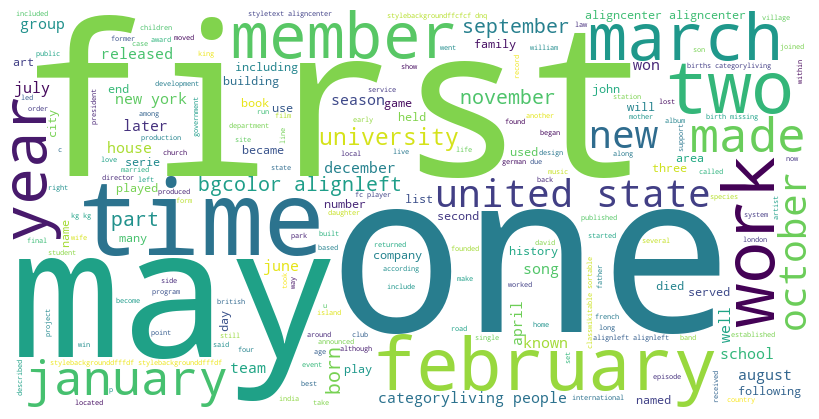

In [23]:
## Display a word cloud

wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(all_text)
plt.figure(figsize = (8, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [30]:
print(len(json_data_cleaned['target'].unique()))

42927


In [36]:
## Display summary statistics for json_data_cleaned['target'] summary statistics

json_data_cleaned['target'].value_counts().describe()

count    42927.000000
mean         6.198430
std         97.186725
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      13177.000000
Name: count, dtype: float64

In [37]:
## Display json_data_cleaned['target'] frequencies for every 5% percentile

# Calculate percentiles for the target frequencies
percentiles = np.arange(0, 1, 0.05)
target_frequencies = json_data_cleaned['target'].value_counts()
percentile_values = np.percentile(target_frequencies.values, percentiles * 100)

# Display the frequencies at each percentile
for i, percentile in enumerate(percentiles):
  print(f"{percentile*100:.0f}% percentile: {percentile_values[i]:.2f}")

0% percentile: 1.00
5% percentile: 1.00
10% percentile: 1.00
15% percentile: 1.00
20% percentile: 1.00
25% percentile: 1.00
30% percentile: 1.00
35% percentile: 1.00
40% percentile: 1.00
45% percentile: 1.00
50% percentile: 1.00
55% percentile: 1.00
60% percentile: 1.00
65% percentile: 2.00
70% percentile: 2.00
75% percentile: 2.00
80% percentile: 3.00
85% percentile: 4.00
90% percentile: 7.00
95% percentile: 14.00


In [231]:
## Drop rows where json_data_cleaned['target'] is not in the top 10 most frequent

# Combine all target words into a single string
all_targets = ' '.join(json_data_cleaned['target'].astype(str))

# Tokenize the target words and count their frequencies
word_counts = Counter(all_targets.split())

# Get the top 10 most frequent words
top_10_words = word_counts.most_common(10)

# Create a set of the top 10 words for efficient lookup
top_10_words_set = set([word for word, count in top_10_words])

# Filter the DataFrame
json_data_cleaned_reduced = json_data_cleaned[json_data_cleaned['target'].isin(top_10_words_set)].reset_index(drop=True)
print(json_data_cleaned_reduced['target'].value_counts().describe())
json_data_cleaned_reduced

count       10.000000
mean      4731.200000
std       3482.128398
min       1508.000000
25%       2316.750000
50%       3851.000000
75%       6108.250000
max      13177.000000
Name: count, dtype: float64


,sentences,masked_sentences,target
0,venter is rounded with gently convex lateral s...,venter is rounded with gently convex lateral s...,on
1,it is similar to neoganides with which it shar...,it <MASK> similar to neoganides with which it ...,is
2,kookoo of the finnish liiga retired his number...,kookoo of the finnish liiga retired his number...,the
3,a,<MASK>,a
4,a,<MASK>,a
...,...,...,...
47307,1966 was the last year that outagamie county h...,1966 <MASK> the last year that outagamie count...,was
47308,with its former name area residents would come...,with its former name area residents would come...,of
47309,the outagamie county asylum cemetery exists no...,the outagamie county asylum cemetery exists no...,and
47310,in 2015 an effort was made to improve the near...,in 2015 an effort was made to improve <MASK> n...,the


The target column is composed of a large number of classes. This indicates that a substantially large corpus of text would be required to get good results such as what is done with modern Large Language Models. Due to this and to reduce training time, the top most frequent 10 words will be kept, resulting in about a 5.6 times decrease in rows in the dataframe. The models attempted here will not perform as well as they did in class projects with binary targets, though it will still result in an interesting attempt.

## Model Architecture, Results, and Analysis

In this section, multiple reccurent neural networks will be attempted and compared. The results and analysis for them will be included.

Transform the data into series usable by keras models. The words will be assigned indexes through tokenization. The sentences will replace each word with the index, then standardize the input length.

In [235]:
## Prepare the train data for the RNN models

X = json_data_cleaned_reduced['masked_sentences']
y = json_data_cleaned_reduced['target']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq)

In [237]:
## Use the tokenizer to transform the target column in json_data_cleaned

y_seq = tokenizer.texts_to_sequences(json_data_cleaned_reduced['target'])
y_pad = pad_sequences(y_seq)
json_data_cleaned_reduced['target_tokenized'] = y_pad.tolist()
json_data_cleaned_reduced

,sentences,masked_sentences,target,target_tokenized
0,venter is rounded with gently convex lateral s...,venter is rounded with gently convex lateral s...,on,[10]
1,it is similar to neoganides with which it shar...,it <MASK> similar to neoganides with which it ...,is,[9]
2,kookoo of the finnish liiga retired his number...,kookoo of the finnish liiga retired his number...,the,[1]
3,a,<MASK>,a,[6]
4,a,<MASK>,a,[6]
...,...,...,...,...
47307,1966 was the last year that outagamie county h...,1966 <MASK> the last year that outagamie count...,was,[8]
47308,with its former name area residents would come...,with its former name area residents would come...,of,[3]
47309,the outagamie county asylum cemetery exists no...,the outagamie county asylum cemetery exists no...,and,[5]
47310,in 2015 an effort was made to improve the near...,in 2015 an effort was made to improve <MASK> n...,the,[1]


In [239]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_pad, test_size = 0.2, random_state = 0)

In [241]:
print(f"Number of observations: {X_train.shape[0]}")
X_train

Number of observations: 37849


array([[    0,     0,     0, ..., 42082,   125,  1407],
       [    0,     0,     0, ...,     7,   519,   257],
       [    0,     0,     0, ..., 80390,   115,  2503],
       ...,
       [    0,     0,     0, ...,     6,  1497, 12159],
       [    0,     0,     0, ..., 12407,   786,  1964],
       [    0,     0,     0, ...,    30,    40,  1226]], dtype=int32)

In [243]:
print(f"Number of observations: {X_test.shape[0]}")
X_test

Number of observations: 9463


array([[    0,     0,     0, ...,     5,   145,   608],
       [    0,     0,     0, ...,     2,  1647,  6089],
       [    0,     0,     0, ...,     2,  2889,  3850],
       ...,
       [    0,     0,     0, ...,  1375,   510,   262],
       [    0,     0,     0, ..., 10826,    18,   844],
       [    0,     0,     0, ...,  2938,     4,  4819]], dtype=int32)

In [245]:
y_train

array([[4],
       [3],
       [3],
       ...,
       [1],
       [9],
       [5]], dtype=int32)

In order to determine the effectiveness of the models, I baseline score will be set to be compared against. This baseline will be determined by using a simple random guess based on the proportion of each class in the testing target set.

In [380]:
## Use a baseline "model" that predicts classes based on their proportional frequency

# Calculate class proportions in y_test
class_counts = np.bincount(y_test.flatten())
class_proportions = class_counts / len(y_test)

# Generate random predictions based on class proportions
y_pred_random = []
for _ in range(len(y_test)):
    predicted_class = np.random.choice(len(class_proportions), p=class_proportions)
    y_pred_random.append(predicted_class)

y_pred_random = np.array(y_pred_random).reshape(-1, 1)
print(y_pred_random, '\n')
frequency = Counter(y_pred_random.flatten())
print(frequency, '\n')

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred_random)
print("Random Guessing Classifier Accuracy:", accuracy)

[[1]
 [3]
 [1]
 ...
 [3]
 [7]
 [1]] 

Counter({1: 2531, 4: 1314, 3: 1284, 5: 1053, 6: 865, 7: 653, 8: 561, 9: 496, 10: 386, 11: 320}) 

Random Guessing Classifier Accuracy: 0.14340061291345238


Simple RNN, LSTM, and GRU architectures will be used. Also, some other hyperparemeters such as the number of epochs, and optimzer will be tuned for comparison. For the most part, parameters will stay consistent with model 1 for the best comparison. The models used will include:

1. Simple RNN.
2. BILSTM.
3. GRU.
4. Simple RNN using SGD optimizer instead of adam.
5. Simple RNN using adagrad optimizer instead of adam.
6. Simple RNN using 2 layers.
7. Simple RNN with 10 epochs instead of 5.

The score to beat is the approximate accuracy of 0.143 (14.3)%, slightly changes when cell is rerun every time) from the baseline model.

#### Models

##### Model 1

In [251]:
## Build the Simple RNN model

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    layers.SimpleRNN(100),
    layers.Dense(vocab_size, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

start_time = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs = 5,
                    validation_split = 0.2,
                    batch_size = 128
                    )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 349ms/step - accuracy: 0.1917 - loss: 5.4081 - val_accuracy: 0.2720 - val_loss: 2.1108
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 85s 360ms/step - accuracy: 0.2795 - loss: 2.1050 - val_accuracy: 0.2720 - val_loss: 2.1088
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 86s 362ms/step - accuracy: 0.2828 - loss: 2.0928 - val_accuracy: 0.2720 - val_loss: 2.1076
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 86s 361ms/step - accuracy: 0.2781 - loss: 2.1030 - val_accuracy: 0.2720 - val_loss: 2.1049
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 86s 362ms/step - accuracy: 0.2764 - loss: 2.0987 - val_accuracy: 0.2720 - val_loss: 2.1053
Elapsed time: 7.09 minutes
Results:
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.2776 - loss: 2.0998
Validation Loss: 2.1044
Validation Accuracy: 0.2752


In [253]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 86759)          │     8,762,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,347,129 (150.10 MB)

 Trainable params: 13,115,709 (50.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,231,420 (100.06 MB)

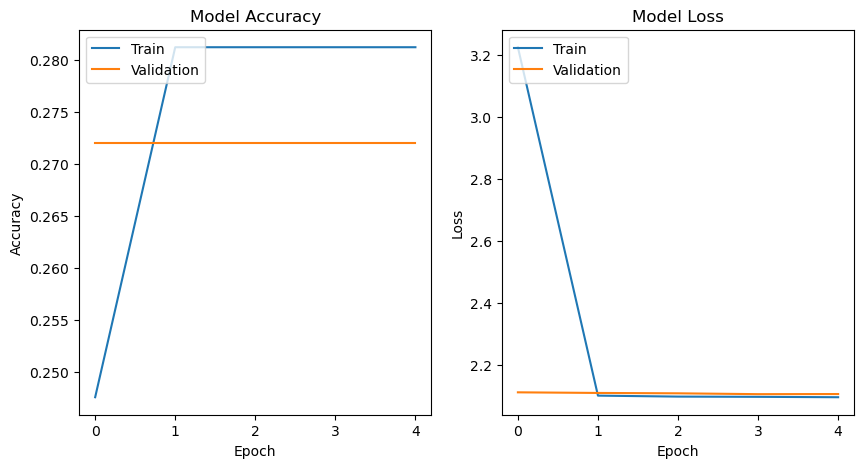

In [255]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [265]:
## Calculate accuracy

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

Classifier Accuracy: 0.27517700517806193


##### Model 2

In [269]:
## Build the Bidirectional LSTM model

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model_bilstm = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    Bidirectional(LSTM(100)),
    layers.Dense(vocab_size, activation = 'softmax')
])

model_bilstm.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics =[ 'accuracy'])


start_time = time.time()
history_bilstm = model_bilstm.fit(X_train,
                                 y_train,
                                 epochs = 5,
                                 validation_split = 0.2,
                                 batch_size = 128
                                 )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("Bidirectional LSTM Results:")
loss_bilstm, accuracy_bilstm = model_bilstm.evaluate(X_test, y_test)
print(f"Validation Loss: {loss_bilstm:.4f}")
print(f"Validation Accuracy: {accuracy_bilstm:.4f}")

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.2802 - loss: 4.8634 - val_accuracy: 0.2720 - val_loss: 2.1176
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.2831 - loss: 2.0972 - val_accuracy: 0.2720 - val_loss: 2.1090
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.2810 - loss: 2.1002 - val_accuracy: 0.2720 - val_loss: 2.1104
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.2820 - loss: 2.0982 - val_accuracy: 0.2720 - val_loss: 2.1177
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - accuracy: 0.2788 - loss: 2.0939 - val_accuracy: 0.2720 - val_loss: 2.1110
Elapsed time: 25.15 minutes
Bidirectional LSTM Results:
296/296 ━━━━━━━━━━━━━━━━━━━━ 27s 92ms/step - accuracy: 0.2776 - loss: 2.1060
Validation Loss: 2.1098
Validation Accuracy: 0.2752


In [270]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 86759)          │     8,762,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,347,129 (150.10 MB)

 Trainable params: 13,115,709 (50.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,231,420 (100.06 MB)

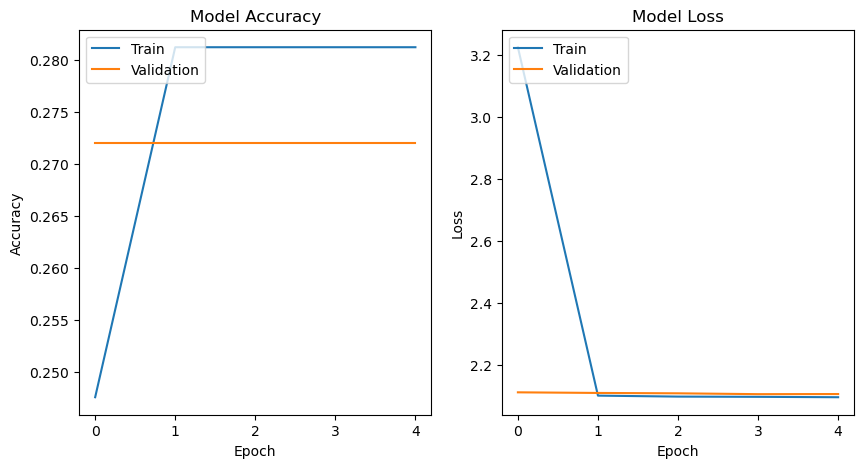

In [271]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [283]:
## Calculate accuracy

y_pred = model_bilstm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

296/296 ━━━━━━━━━━━━━━━━━━━━ 26s 89ms/step
Classifier Accuracy: 0.27517700517806193


##### Model 3

In [348]:
## Build the GRU model

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model_gru = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    layers.GRU(100),
    layers.Dense(vocab_size, activation = 'softmax')
])

model_gru.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


start_time = time.time()
history_gru = model_gru.fit(X_train,
                                 y_train,
                                 epochs = 5,
                                 validation_split = 0.2,
                                 batch_size = 128
                                 )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("GRU Results:")
loss_gru, accuracy_gru = model_gru.evaluate(X_test, y_test)
print(f"Validation Loss: {loss_gru:.4f}")
print(f"Validation Accuracy: {accuracy_gru:.4f}")

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 223s 938ms/step - accuracy: 0.2688 - loss: 5.9429 - val_accuracy: 0.2720 - val_loss: 2.1137
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 217s 918ms/step - accuracy: 0.2810 - loss: 2.1038 - val_accuracy: 0.2720 - val_loss: 2.1059
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 218s 918ms/step - accuracy: 0.2786 - loss: 2.1019 - val_accuracy: 0.2720 - val_loss: 2.1030
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 215s 907ms/step - accuracy: 0.2807 - loss: 2.0980 - val_accuracy: 0.2720 - val_loss: 2.1078
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 216s 910ms/step - accuracy: 0.2779 - loss: 2.0973 - val_accuracy: 0.2720 - val_loss: 2.1065
Elapsed time: 18.14 minutes
GRU Results:
296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.2776 - loss: 2.0997
Validation Loss: 2.1052
Validation Accuracy: 0.2752


In [349]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 86759)          │     8,762,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,347,129 (150.10 MB)

 Trainable params: 13,115,709 (50.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,231,420 (100.06 MB)

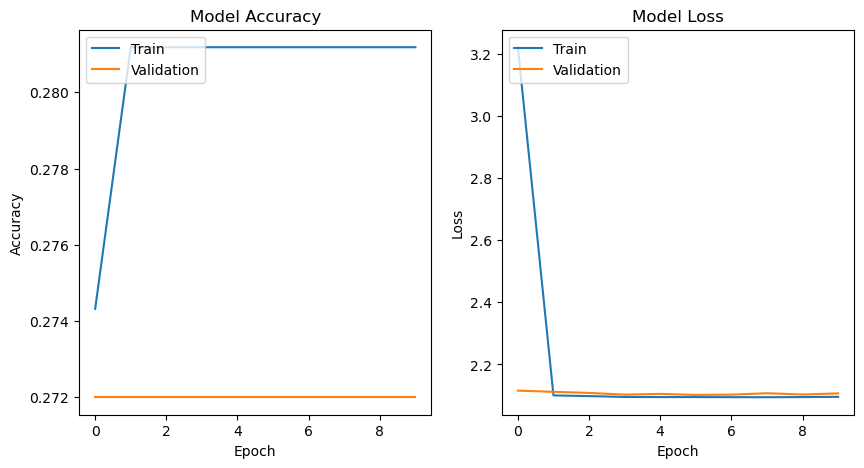

In [350]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [351]:
## Calculate accuracy

y_pred = model_gru.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

296/296 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step
Classifier Accuracy: 0.27517700517806193


##### Model 4

In [310]:
## Build the Simple RNN model using sgd optimizer

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    layers.SimpleRNN(100),
    layers.Dense(vocab_size, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

start_time = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs = 5,
                    validation_split = 0.2,
                    batch_size = 128
                    )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 347ms/step - accuracy: 0.2577 - loss: 8.7177 - val_accuracy: 0.2720 - val_loss: 2.6009
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 356ms/step - accuracy: 0.2785 - loss: 2.3844 - val_accuracy: 0.2720 - val_loss: 2.1564
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 355ms/step - accuracy: 0.2824 - loss: 2.1346 - val_accuracy: 0.2720 - val_loss: 2.1251
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 349ms/step - accuracy: 0.2795 - loss: 2.1168 - val_accuracy: 0.2720 - val_loss: 2.1171
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 344ms/step - accuracy: 0.2825 - loss: 2.1045 - val_accuracy: 0.2720 - val_loss: 2.1139
Elapsed time: 6.93 minutes
Results:
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2776 - loss: 2.1087
Validation Loss: 2.1143
Validation Accuracy: 0.2752


In [311]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 86759)          │     8,762,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,115,711 (50.03 MB)

 Trainable params: 13,115,709 (50.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

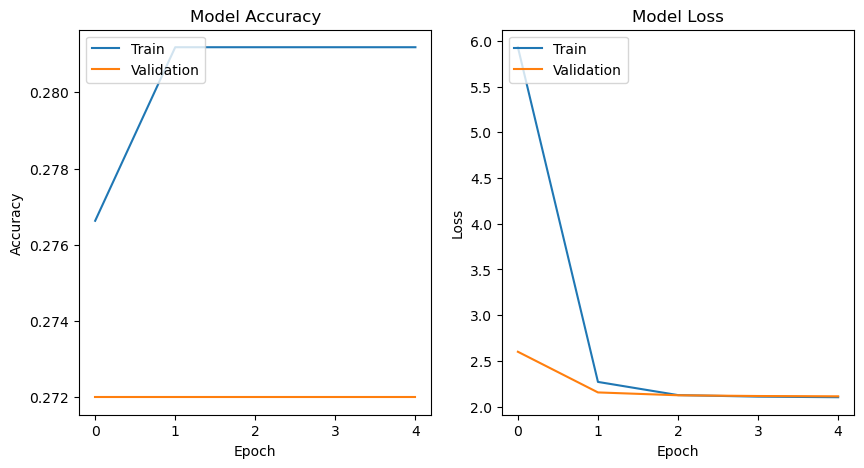

In [312]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [313]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
Classifier Accuracy: 0.27517700517806193


##### Model 5

In [314]:
## Build the Simple RNN model using adagras optimizer

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    layers.SimpleRNN(100),
    layers.Dense(vocab_size, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adagrad', metrics = ['accuracy'])

start_time = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs = 5,
                    validation_split = 0.2,
                    batch_size = 128
                    )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 88s 370ms/step - accuracy: 0.1778 - loss: 11.2153 - val_accuracy: 0.2720 - val_loss: 10.0641
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 374ms/step - accuracy: 0.2802 - loss: 9.5730 - val_accuracy: 0.2720 - val_loss: 8.2101
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 88s 372ms/step - accuracy: 0.2854 - loss: 7.8160 - val_accuracy: 0.2720 - val_loss: 6.8022
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 374ms/step - accuracy: 0.2826 - loss: 6.5031 - val_accuracy: 0.2720 - val_loss: 5.7402
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 374ms/step - accuracy: 0.2802 - loss: 5.5130 - val_accuracy: 0.2720 - val_loss: 4.9117
Elapsed time: 7.38 minutes
Results:
296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.2776 - loss: 4.9056
Validation Loss: 4.9140
Validation Accuracy: 0.2752


In [315]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_13 (SimpleRNN)       │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 86759)          │     8,762,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,231,420 (100.06 MB)

 Trainable params: 13,115,709 (50.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,115,711 (50.03 MB)

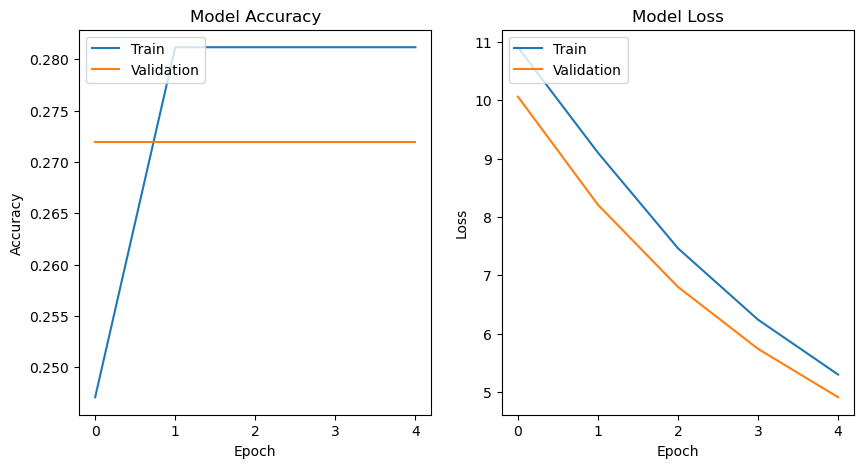

In [316]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [317]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

296/296 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Classifier Accuracy: 0.27517700517806193


##### Model 6

In [318]:
## Build the Simple RNN model with 2 SimpleRNN layers

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    layers.SimpleRNN(100, return_sequences=True),
    layers.SimpleRNN(50),
    layers.Dense(vocab_size, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

start_time = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs = 5,
                    validation_split = 0.2,
                    batch_size = 128
                    )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 129s 543ms/step - accuracy: 0.2417 - loss: 6.7365 - val_accuracy: 0.2720 - val_loss: 2.1439
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 129s 544ms/step - accuracy: 0.2788 - loss: 2.1239 - val_accuracy: 0.2720 - val_loss: 2.1150
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 129s 544ms/step - accuracy: 0.2855 - loss: 2.0950 - val_accuracy: 0.2720 - val_loss: 2.1079
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 129s 545ms/step - accuracy: 0.2832 - loss: 2.0955 - val_accuracy: 0.2720 - val_loss: 2.1048
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 129s 543ms/step - accuracy: 0.2811 - loss: 2.0965 - val_accuracy: 0.2720 - val_loss: 2.1056
Elapsed time: 10.75 minutes
Results:
296/296 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.2776 - loss: 2.1004
Validation Loss: 2.1055
Validation Accuracy: 0.2752


In [319]:
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_14 (SimpleRNN)       │ (None, 1147, 100)      │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_15 (SimpleRNN)       │ (None, 50)             │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 86759)          │     4,424,709 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,355,929 (100.54 MB)

 Trainable params: 8,785,309 (33.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,570,620 (67.03 MB)

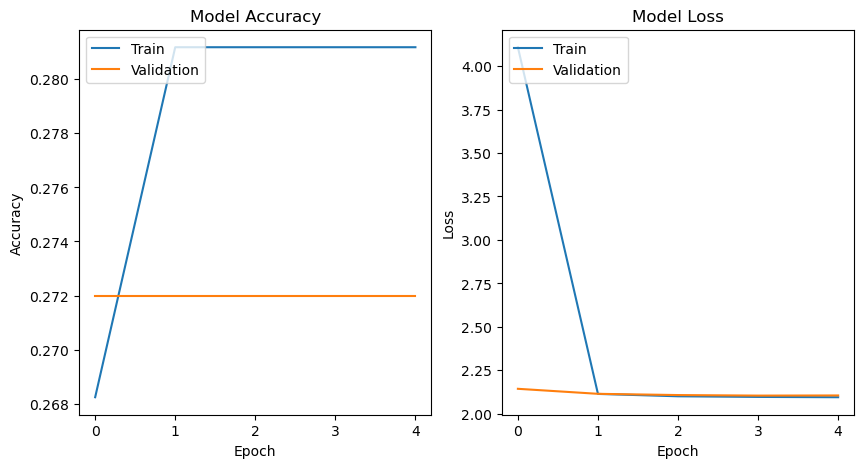

In [320]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [321]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

296/296 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step
Classifier Accuracy: 0.27517700517806193


##### Model 7

In [331]:
## Build the Simple RNN model with 10 epochs

vocab_size = len(tokenizer.word_index) + 1 # Size of vocabulary
embedding_dim = 50 # Dimension of word embeddings
max_length = X_train.shape[1] # Maximum length of input sequences

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    layers.SimpleRNN(100),
    layers.Dense(vocab_size, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

start_time = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs = 10,
                    validation_split = 0.2,
                    batch_size = 128
                    )
end_time = time.time()
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

print("Results:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 353ms/step - accuracy: 0.2489 - loss: 5.4028 - val_accuracy: 0.2720 - val_loss: 2.1158
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 354ms/step - accuracy: 0.2812 - loss: 2.0996 - val_accuracy: 0.2720 - val_loss: 2.1120
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 350ms/step - accuracy: 0.2762 - loss: 2.1052 - val_accuracy: 0.2720 - val_loss: 2.1084
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 374ms/step - accuracy: 0.2805 - loss: 2.0982 - val_accuracy: 0.2720 - val_loss: 2.1030
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 368ms/step - accuracy: 0.2838 - loss: 2.0932 - val_accuracy: 0.2720 - val_loss: 2.1052
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 368ms/step - accuracy: 0.2779 - loss: 2.0970 - val_accuracy: 0.2720 - val_loss: 2.1021
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 352ms/step - accuracy: 0.2848 - loss: 2.0938 - val_accuracy: 0.2720 - val_loss: 2.1029
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 354ms/step - accuracy: 0.2824 - loss: 2.0923 - val

In [332]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 1147, 50)       │     4,337,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 86759)          │     8,762,659 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,347,129 (150.10 MB)

 Trainable params: 13,115,709 (50.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,231,420 (100.06 MB)

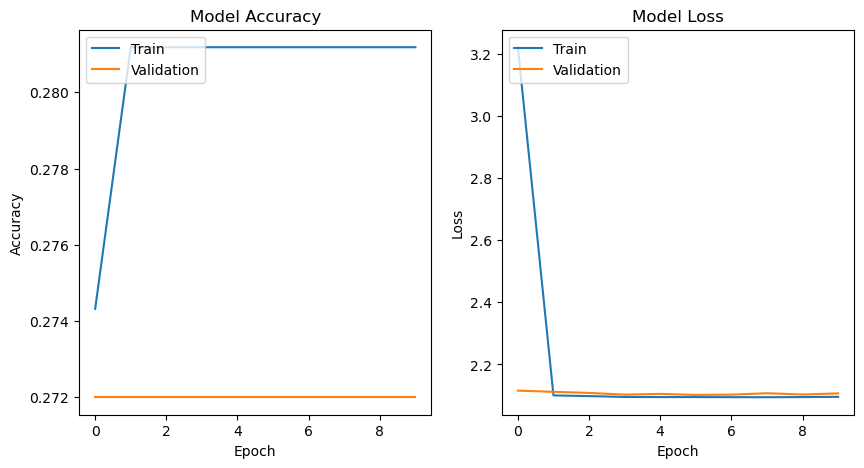

In [333]:
## Visualize the model performance over the epochs and generate results on the test data.

plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [334]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.argmax(axis=1))
print("Classifier Accuracy:", accuracy)

296/296 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step
Classifier Accuracy: 0.27517700517806193


## Conclusion and Future Work
In terms of Conclusions:

Based on the results, the models compared similarily with an approximate score of 0.275 (27.5%) accuracy. This is approximately twice the performance of the baseline model.

Some observations of interest include the fact that each models accuracy maintained at just 1 epoch of training, indicating more epochs are not required for the models. This is the same case for the model loss based on the visualizations displayed, with the exception of the classifier with adagrad optimization that continued to decrease in both train and validation loss.

Considering the performances were similar across classifiers, the best model would be the Simple RNN at 5 epochs using adam optimizer and sgd loss. This is due to the fact that is trained the fastest at < 7 minutes total training time.

For Future Work:

There are a variety of methods that can be considered for experimentation in this project. Standardizing the the class proportion by downsampling classes to the smallest class could be attempted. While more epochs do not appear to increase model performance, the use of more data could add context for words. Essentially, increase the number of input sentences for each target class.

More types of feature engineering such as keep the entire article or paragraph as the input, masking only 1 word in the whole article. Paired with more data, this would provide a substantial amount of input data, increasing train times, but potentially increasing model performance. The use of more layers, neuron counts, and tweaking other aspects of the model hyparameters can also be attempted.

Proper language models would also include more target variables, or attempt to link an entire vocabularly rather than just the 10 targets attempted here, so adding more targets could make for a more general effective model.